In [5]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
import scipy.stats as ss
import gensim
from sklearn.decomposition import PCA

CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)


In [12]:
class ProdIterableDataset(IterableDataset):
    
    def __init__(self, transactions, products, full_hierarchy=False):
        self.transactions = transactions
        self.products = products
        self.iterations = 0
        
        self.NS = 5
        self.negative_sampling_p = NEGATIVE_SAMPLING_PROBABILITY
        self.neg_stack = []
        self.i = 0
        self.rows = 0
        self.return_hierarchy = full_hierarchy
        
    def negative_sampling(self, x, y):
        negs = []
        while len(negs) < self.NS:
            if self.i == len(self.neg_stack):
                self.neg_stack = [self.products[z] for z in np.random.multinomial(1e7, self.negative_sampling_p)]
                self.i = 0
            new = self.neg_stack[self.i]
            self.i += 1
            if new != x and new != y:
                negs.append(new)
        #print(k)
        return negs
    
    def parse_dataset(self, start=0, end=0):
        if start or end:
            to_iter = list(self.transactions)[start:end]
        else:
            to_iter = self.transactions
        
        for transaction in to_iter:
            row = [self.products[i] for i in transaction.indices if np.random.rand() > DOWNSAMPLE_PROBABILITY[i]]
            for x, y in permutations(row, 2):
                if self.return_hierarchy:
                    yield (x.hierarchy_indices, y.hierarchy_indices, *[z.hierarchy_indices for z in self.negative_sampling(x,y)])
                else:
                    yield (x.index, y.index, *[z.index for z in self.negative_sampling(x,y)])
            self.rows += 1
        self.iterations += 1
        self.rows = 0
        
    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:  # single-process data loading, return the full iterator
            return self.parse_dataset()
        per_worker = int(math.ceil(len(self.transactions) / float(worker_info.num_workers)))
        worker_id = worker_info.id
        iter_start = worker_id * per_worker
        iter_end = min(iter_start + per_worker, len(self.transactions))
        print(worker_id, iter_start, iter_end)
        return self.parse_dataset(iter_start, iter_end)
            
    
ds = ProdIterableDataset(transactions, products, True)
loader = DataLoader(ds, batch_size=50000)

start = time.time()
#for batch in islice(loader, 1):
#    print(batch[0].shape, batch[1].shape, torch.stack(batch[2:]).transpose(1,0).shape, batch[0][:3, -1], batch[1][:3, -1])
print(time.time() - start)

ds = ProdIterableDataset(transactions, products, False)
loader = DataLoader(ds, batch_size=50000)

start = time.time()
for batch in islice(loader, 1):
    print(batch[0].shape, batch[1].shape, torch.stack(batch[2:]).transpose(1,0).shape, batch[0][:3], batch[1][:3])
time.time() - start

0.0
torch.Size([50000]) torch.Size([50000]) torch.Size([50000, 5]) tensor([33888, 33888,  3716]) tensor([ 3716, 36373, 33888])


1.2741029262542725

In [13]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size: int, emb_dimension: int=100):
        super(SkipGram, self).__init__()
        self.vocab_size = vocab_size
        self.emb_dimension = emb_dimension
        self.u_embeddings = nn.Embedding(vocab_size, emb_dimension, sparse=True)
        self.v_embeddings = nn.Embedding(vocab_size, emb_dimension, sparse=True)
        
        initrange = 0.5 / self.emb_dimension
        self.u_embeddings.weight.data.uniform_(-initrange, initrange)
        self.v_embeddings.weight.data.uniform_(0,0)

    def forward(self, pos_u, pos_v, neg_v):
        emb_u = self.u_embeddings(pos_u)  # batch_size * emb_size
        #print(emb_u.shape)
        emb_v = self.v_embeddings(pos_v)  # batch_size * emb_size
        emb_neg = self.v_embeddings(neg_v)  # batch_size * neg sample size * emb_size
        #print(emb_u.shape, emb_v.shape, emb_neg.shape)
        
        pos_score = torch.mul(emb_u, emb_v).squeeze()      
        pos_score = torch.sum(pos_score, dim=1)
        pos_score = F.logsigmoid(pos_score)
        likelihood = torch.sum(pos_score)
        neg_score = torch.bmm(emb_neg, emb_u.unsqueeze(2)).squeeze()
       
        neg_score = F.logsigmoid(-neg_score)
        likelihood += torch.sum(neg_score)
        return -1 * likelihood
    
    def predict_proba(self, u):
        emb_u = self.u_embeddings(u)
        proba = torch.matmul(emb_u, self.v_embeddings.weight.T)
        proba = nn.Softmax(dim=1)(proba).cpu().detach().numpy()
        return proba
    
    def predict_proba_vector(self, u_vec):
        emb_u = self.u_embeddings(u_vec)
        emb_u = torch.sum(emb_u, 0)
        proba = torch.matmul(emb_u, self.v_embeddings.weight.T)
        res = nn.Softmax(dim=0)(proba).cpu().detach().numpy().flatten()
        return res

In [14]:
class MetaSkipGram(nn.Module):
    def __init__(self, vocab_size: int, emb_dimension: int, input_hierarchy=(0,1,2,3), output_hierarchy=(0,1,2,3)):
        super(MetaSkipGram, self).__init__()
        self.vocab_size = vocab_size
        self.emb_dimension = emb_dimension
        self.u_embeddings = nn.Embedding(vocab_size, emb_dimension, sparse=True)
        self.v_embeddings = nn.Embedding(vocab_size, emb_dimension, sparse=True)
        
        initrange = 0.5 / self.emb_dimension
        torch.manual_seed(10)
        self.u_embeddings.weight.data.uniform_(-initrange, initrange)
        self.v_embeddings.weight.data.uniform_(0,0)
        self.ih = input_hierarchy
        self.oh = output_hierarchy

    def forward(self, pos_u, pos_v, neg_v):
        emb_u = self.u_embeddings(pos_u)  # batch_size * h_size * emb_size
        emb_v = self.v_embeddings(pos_v)  # batch_size * h_size * emb_size
        emb_neg = self.v_embeddings(neg_v)  # batch_size * neg sample size * h_size * emb_size
        #print(emb_u.shape, emb_v.shape, emb_neg.shape)
        likelihood = 0
        
        for input_hierarchy in self.ih:
            for output_hierarchy in self.oh:
                pos_score = torch.mul(emb_u[:, input_hierarchy, :], emb_v[:,output_hierarchy,:]).squeeze()
                pos_score = torch.sum(pos_score, dim=1)
                #print(pos_score.shape)
                pos_score = F.logsigmoid(pos_score)
                likelihood += torch.sum(pos_score)#*c

                neg_score = torch.bmm(emb_neg[:, :, output_hierarchy, :], emb_u[:, input_hierarchy, :].unsqueeze(2)).squeeze()
                #else:
                #neg_score = torch.bmm(emb_neg[:, :1, output_hierarchy, :], emb_u[:, input_hierarchy, :].unsqueeze(2)).squeeze()/2
                #neg_score = torch.bmm(emb_neg[:, :, output_hierarchy, :], emb_u[:, input_hierarchy, :].unsqueeze(2)).squeeze()
                neg_score = F.logsigmoid(-neg_score)
                #print(neg_score.shape)
                likelihood += torch.sum(neg_score)#*c
        return -1 * likelihood
    
    def predict_proba(self, u):
        emb_u = self.u_embeddings(u)
        proba = torch.matmul(emb_u, self.v_embeddings.weight.T[:, sum(LEVEL_SIZE[:-1]):])
        proba = nn.Softmax(dim=1)(proba).cpu().detach().numpy()
        return proba
    
    def predict_proba_vector(self, u_vec):
        emb_u = self.u_embeddings(u_vec)
        emb_u = torch.sum(emb_u, 0)
        proba = torch.matmul(emb_u, self.v_embeddings.weight.T[:, sum(LEVEL_SIZE[:-1]):])
        proba = nn.Softmax(dim=0)(proba).cpu().detach().numpy()
        return proba

In [15]:
def get_conditional_probability(nn_model):
    start = 0 if type(nn_model) == SkipGram else sum(LEVEL_SIZE[:-1])
    to_pass = list(range(start, start + len(products)))
    chunks = 10
    c_size = int(np.ceil(len(products)/chunks))
    r = np.zeros((len(products), len(products)), dtype='float32')
    for i in range(chunks):
        input_vector = torch.LongTensor(to_pass[i*c_size:(i+1)*c_size]).to(DEVICE)
        r[i*c_size:(i+1)*c_size] = nn_model.predict_proba(input_vector)
        del input_vector
    r += 1e-10
    r = np.log(r)
    return r

def predict_from_cocounts():
    table = np.zeros((len(products), len(products)), dtype='float32')
    for t in transactions:
        for x, y in permutations(t.indices, 2):
            table[x,y] += 1
   
    table = table / table.sum(axis=1)[:, np.newaxis]    
    table = np.log(table + 1e-10)
    return predict_from_conditional_probability_model(table)
 
def predict_from_conditional_probability_model(conditional_log_probabilities):
    predicted_rank = []
    
    for t in transactions:
        if t.test_item is not None:
            resulting_proba = conditional_log_probabilities[t.indices].sum(axis=0)
            resulting_proba[t.indices] = -np.inf
            real = t.test_item
            rank = np.sum(resulting_proba >= resulting_proba[real]) + 1
            #len([x for x in resulting_proba if x >= resulting_proba[real]])
            predicted_rank.append(rank)
    return predicted_rank

def predict_from_nn_model(nn_model):
    return predict_from_conditional_probability_model(get_conditional_probability(nn_model))

def predict_from_nn_model_sequence(nn_model):
    predicted_rank = []
    with torch.set_grad_enabled(False):
        for t in transactions:
            if t.test_item is not None:
                input_vector = torch.LongTensor(t.indices).to(DEVICE) if type(nn_model) == SkipGram else torch.LongTensor([INDEX_OF[x] for x in t.barcodes]).to(DEVICE)
                proba = nn_model.predict_proba_vector(input_vector)
                proba[t.indices] = 0
                real = t.test_item
                rank = np.sum(proba >= proba[real]) + 1
                predicted_rank.append(rank)
                del input_vector
    return predicted_rank

def predict_from_embedding(embedding, use_norms='no'):
    predicted_rank = []
    if use_norms == 'cosine':
        normalized = normalize(embedding)
    if use_norms == 'distance':
        norms = np.linalg.norm(embedding, axis=1)**2
    for t in transactions:
        if t.test_item is not None:
            vector = embedding[t.indices].mean(axis=0)
            
            if use_norms == 'cosine':
                dot_product = np.dot(vector, normalized.T)
            else:
                dot_product = np.dot(vector, embedding.T)
            if use_norms == 'distance':
                dot_product = -norms + 2*dot_product
            dot_product[t.indices] = -np.inf
            real = t.test_item
            rank = np.sum(dot_product >= dot_product[real]) + 1
            #len([x for x in resulting_proba if x >= resulting_proba[real]])
            predicted_rank.append(rank)
            if len(predicted_rank) == 10000:
                break
    return predicted_rank

def HR(predicted_rank, k=10):
    return np.mean([1*(i<=k) for i in predicted_rank])

def NDCG(predicted_rank, k=10):
    return np.mean([1/np.log2(2+i)*(i<=k) for i in predicted_rank])


In [16]:
def train_nn_model(ds, model, optimizer, scheduler=None, epochs=5, batch_size=5000, print_per_batches=4000, test_function=None):
    loader = DataLoader(ds, batch_size=batch_size)
    model.to(DEVICE)
    logs = []
    for epoch in range(epochs):
        epoch_loss = 0
        start = time.time()
        batch_counter = 0
        loss_gathered = 0
        
        for batch_sample in loader:
            #if type(model) == SkipGram:
            x, y, neg = batch_sample[0].to(DEVICE), batch_sample[1].to(DEVICE), torch.stack(batch_sample[2:]).transpose(1,0).to(DEVICE)
            #else:
            #    x, y, neg = batch_sample[0][:, 2:].to(DEVICE), batch_sample[1][:, 2:].to(DEVICE), torch.stack(batch_sample[2:]).transpose(1,0)[:, 2:].to(DEVICE)
            
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                loss = model(x, y, neg)
                loss.backward()
                optimizer.step()
            loss_gathered += loss.item()/batch_size
            #print(loss.item()/batch_size)
            epoch_loss += loss.item()/batch_size
            batch_counter += 1
            if batch_counter%print_per_batches == 0:
                print(int(batch_counter*batch_size/1000000),'M in', int(time.time()-start),'loss', round(loss_gathered/print_per_batches, 3))
                loss_gathered = 0
        print(epoch, 'Epoch is over in', int(time.time()-start), 's. Average epoch loss:', epoch_loss/batch_counter)
        if test_function:
            with torch.set_grad_enabled(False):
                log = test_function(model, epoch)
                logs += [x+[epoch_loss/batch_counter] for x in log]
        if scheduler:
            scheduler.step()
    if len(logs):
        return logs

def test_nn_model(nn_model, epoch):
    log = []
    #ranks = predict_from_nn_model(nn_model)
    #print('Per-word NN probability model. HR@10: {:.2f}%. NDCG@10: {:.2f}%.'.format(HR(ranks)*100, NDCG(ranks)*100))
    #log.append(['ProductNN', HR(ranks), NDCG(ranks), epoch])
    ranks = predict_from_nn_model_sequence(nn_model)
    print('Sequence NN probability model. HR@10: {:.2f}%. NDCG@10: {:.2f}%.'.format(HR(ranks)*100, NDCG(ranks)*100))
    log.append(['SequenceNN', HR(ranks), NDCG(ranks), epoch])
    embedding = nn_model.u_embeddings.weight.cpu().data.numpy()
    if type(nn_model) == MetaSkipGram:
        embedding = embedding[sum(LEVEL_SIZE[:-1]):, :]
    #ranks = predict_from_embedding(embedding, 'distance')
    #print('Embedding distance from mean. HR@10: {:.2f}%. NDCG@10: {:.2f}%.'.format(HR(ranks)*100, NDCG(ranks)*100))
    ranks = predict_from_embedding(embedding, 'cosine')
    print('Embedding cosine similarity. HR@10: {:.2f}%. NDCG@10: {:.2f}%.'.format(HR(ranks)*100, NDCG(ranks)*100))
    log.append(['Embedding cosine', HR(ranks), NDCG(ranks), epoch])
    ranks = predict_from_embedding(embedding)
    print('Embedding shifted cosine similarity. HR@10: {:.2f}%. NDCG@10: {:.2f}%.'.format(HR(ranks)*100, NDCG(ranks)*100))
    log.append(['Embedding shifted cosine', HR(ranks), NDCG(ranks), epoch])
    return log

def run_experiment(hidden_size, learning_rate, gamma=1, epochs=5, batch_size=5000, print_per_batches=4000, input_output_hierarchy=None):
    hierarchy = input_output_hierarchy is not None
    ds = ProdIterableDataset(transactions, products, full_hierarchy=hierarchy)
    nn_model = MetaSkipGram(sum(LEVEL_SIZE), hidden_size, *input_output_hierarchy) if hierarchy else SkipGram(LEVEL_SIZE[-1], hidden_size)
    optimizer = optim.SGD(nn_model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
    logs = train_nn_model(ds, nn_model, optimizer, scheduler, test_function=test_nn_model, epochs=epochs, batch_size=batch_size, print_per_batches=print_per_batches)
    for x in logs:
        x.append(hidden_size)
        x.append(learning_rate)
        x.append(gamma)
        if hierarchy:
            x.append((min(input_output_hierarchy[0]), min(input_output_hierarchy[1])))
        else:
            x.append(('barcode'))
    return nn_model, logs

logs = []

In [89]:
nn_model, new_logs = run_experiment(100, 1e-4, 1, 10, print_per_batches=1000)
logs += new_logs

[]

In [11]:
nn_model, new_logs = run_experiment(100, 2e-4, 1, 10, print_per_batches=5000)
logs += new_logs

25 M in 225 loss 3.557
50 M in 445 loss 1.363
0 Epoch is over in 488 s. Average epoch loss: 2.328009284663511
Per-word NN probability model. HR@10: 4.67%. NDCG@10: 2.11%.
Sequence NN probability model. HR@10: 4.94%. NDCG@10: 2.20%.
Embedding cosine similarity. HR@10: 4.26%. NDCG@10: 1.82%.
Embedding shifted cosine similarity. HR@10: 4.67%. NDCG@10: 2.11%.
25 M in 223 loss 0.86
50 M in 446 loss 0.683
1 Epoch is over in 489 s. Average epoch loss: 0.759545265537559
Per-word NN probability model. HR@10: 4.64%. NDCG@10: 2.09%.
Sequence NN probability model. HR@10: 5.85%. NDCG@10: 2.50%.
Embedding cosine similarity. HR@10: 3.02%. NDCG@10: 1.14%.
Embedding shifted cosine similarity. HR@10: 4.60%. NDCG@10: 1.84%.
25 M in 228 loss 0.612
50 M in 439 loss 0.543
2 Epoch is over in 479 s. Average epoch loss: 0.5731382974509796
Per-word NN probability model. HR@10: 4.63%. NDCG@10: 2.11%.
Sequence NN probability model. HR@10: 6.36%. NDCG@10: 2.70%.
Embedding cosine similarity. HR@10: 1.76%. NDCG@10: 

In [16]:
nn_model, new_logs = run_experiment(100, 1e-4, 1, 10, print_per_batches=1000)
logs += new_logs

5 M in 38 loss 3.466
10 M in 77 loss 3.466
15 M in 116 loss 3.466
20 M in 154 loss 3.465
25 M in 193 loss 3.462
30 M in 231 loss 3.438
35 M in 270 loss 3.322
40 M in 308 loss 3.067
45 M in 347 loss 2.771
50 M in 385 loss 2.452
0 Epoch is over in 423 s. Average epoch loss: 3.1407435887167923
Per-word NN probability model. HR@10: 4.58%. NDCG@10: 2.10%.
Sequence NN probability model. HR@10: 4.58%. NDCG@10: 2.10%.
Embedding cosine similarity. HR@10: 4.22%. NDCG@10: 1.86%.
Embedding shifted cosine similarity. HR@10: 4.43%. NDCG@10: 2.07%.


KeyboardInterrupt: 

In [13]:
nn_model, new_logs = run_experiment(100, 5e-5, 1, 10, print_per_batches=5000)
logs += new_logs

25 M in 188 loss 4.159
50 M in 377 loss 4.142
0 Epoch is over in 414 s. Average epoch loss: 4.137238780688393
Per-word NN probability model. HR@10: 4.64%. NDCG@10: 2.10%.
Sequence NN probability model. HR@10: 4.64%. NDCG@10: 2.10%.
Embedding cosine similarity. HR@10: 4.02%. NDCG@10: 1.75%.
Embedding shifted cosine similarity. HR@10: 4.65%. NDCG@10: 2.12%.
25 M in 189 loss 3.376
50 M in 378 loss 2.307
1 Epoch is over in 415 s. Average epoch loss: 2.756212801187567
Per-word NN probability model. HR@10: 4.64%. NDCG@10: 2.10%.
Sequence NN probability model. HR@10: 4.64%. NDCG@10: 2.10%.
Embedding cosine similarity. HR@10: 4.19%. NDCG@10: 1.82%.
Embedding shifted cosine similarity. HR@10: 4.67%. NDCG@10: 2.13%.
25 M in 188 loss 1.634
50 M in 377 loss 1.327
2 Epoch is over in 414 s. Average epoch loss: 1.4570202305566093
Per-word NN probability model. HR@10: 4.65%. NDCG@10: 2.11%.
Sequence NN probability model. HR@10: 4.72%. NDCG@10: 2.13%.
Embedding cosine similarity. HR@10: 4.16%. NDCG@10:

In [65]:
def viz_logs(logs, baselines=None):
    f, ax = plt.subplots(1,3,figsize=(20,6), sharey='row')
    df = pd.DataFrame(logs, columns=['Prediction model', 'HR@10', 'NDCG@10', 'epoch', 'average_epoch_loss', 'hidden_size', 'learning_rate', 'gamma'])
    for i, lr in enumerate(sorted(df.learning_rate.unique())):
        if baselines:
            for name, v in baselines.items():
                ax[i].plot((0,10), (v[0], v[0]), label=name, linestyle='--', color='c' if name.startswith('Popular') else 'y')
        p = sns.lineplot(x='epoch', y='HR@10', data=df[df.learning_rate == lr], hue='Prediction model', ax=ax[i])
        p.set_title('Prediction hit rate for learning rate ' + str(lr) )
    
    f, ax = plt.subplots(1,3,figsize=(20,6), sharey='row')
    for i, lr in enumerate(sorted(df.learning_rate.unique())):
        if baselines:
            for name, v in baselines.items():
                ax[i].plot((0,10), (v[1], v[1]), label=name, linestyle='--', color='c' if name.startswith('Popular') else 'y')
        p = sns.lineplot(x='epoch', y='NDCG@10', data=df[df.learning_rate == lr], hue='Prediction model', ax=ax[i])
        p.set_title('Prediction NDCG for learning rate ' + str(lr) )
    plt.show()

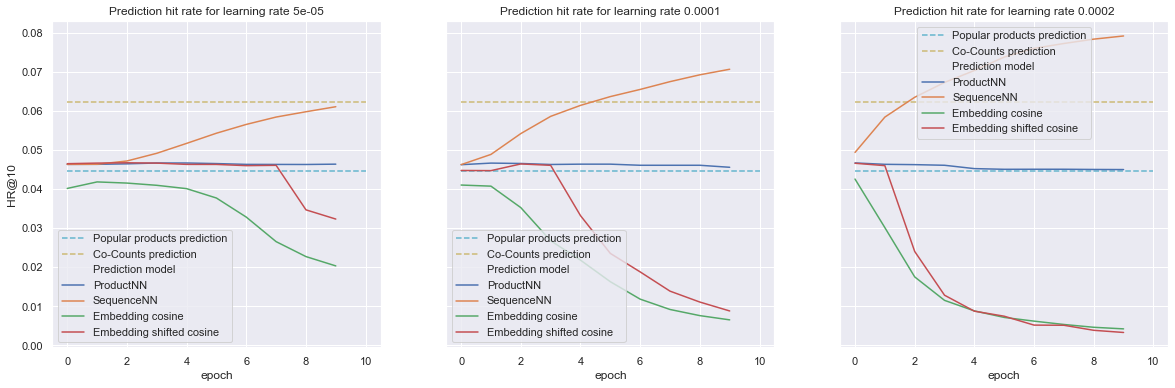

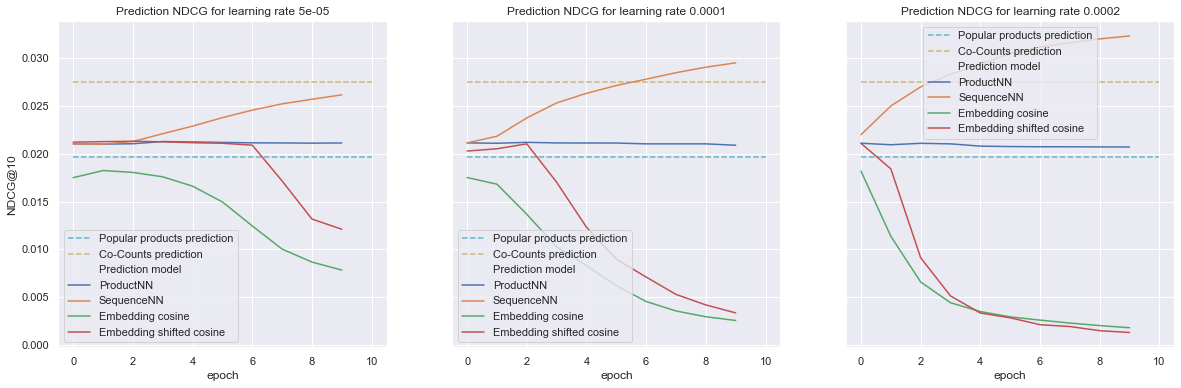

In [67]:
viz_logs(logs, baselines)

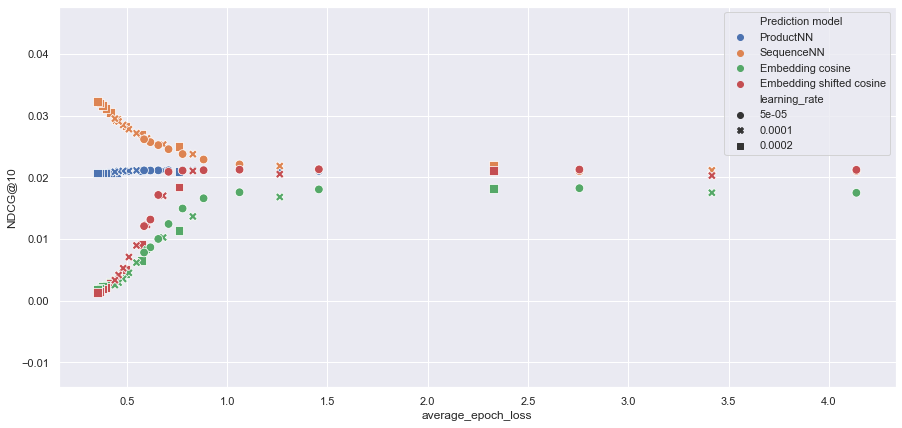

In [27]:
plt.figure(figsize=(15,7))
df = pd.DataFrame(logs, columns=['Prediction model', 'HR@10', 'NDCG@10', 'epoch', 'average_epoch_loss', 'hidden_size', 'learning_rate', 'gamma'])
sns.scatterplot(x='average_epoch_loss', y='NDCG@10', hue='Prediction model', data=df, style='learning_rate', s=75)

In [12]:
  
baselines = {}

product_rating = {v.index: i+1 for i,v in enumerate(list(sorted(products, key=lambda x: x.usages, reverse=True)))}
ranks = []
for t in transactions:
    if t.test_item is not None:
        item_rating = product_rating[t.test_item]
        ranks.append(item_rating - len([x for x in t.indices if product_rating[x] < item_rating]))
print('Popular products prediction. HR@10: {:.2f}%. NDCG@10: {:.2f}%.'.format(HR(ranks)*100, NDCG(ranks)*100))
baselines['Popular products prediction'] = (HR(ranks), NDCG(ranks))

#ranks = predict_from_cocounts()
#print('Co-Counts probability prediction. HR@10: {:.2f}%. NDCG@10: {:.2f}%.'.format(HR(ranks)*100, NDCG(ranks)*100))
#baselines['Co-Counts prediction'] = (HR(ranks), NDCG(ranks))


Popular products prediction. HR@10: 4.52%. NDCG@10: 1.88%.


In [6]:
dataset = [[str(y) for y in x.indices] for x in transactions if len(x.indices) > 1]

In [45]:
def gensim_experiment(it=5, test=False, viz=False, skipgram=False):
    t = 'skipgram' if skipgram else 'CBoW'
    gensim_skipgram = gensim.models.Word2Vec(dataset, window=100, min_count=1, workers=12,sg=skipgram, min_alpha=0.001, iter=it,compute_loss=True, )
    gensim_embeddings = np.vstack([gensim_skipgram.wv[str(i)] for i in range(len(products))])
    print(t+str(it)+' finished. Loss:', gensim_skipgram.get_latest_training_loss()/it, 'Mean embedding norm:', np.linalg.norm(gensim_embeddings, axis=1).mean())
    if test:
        ranks = predict_from_embedding(gensim_embeddings)
        print('Gensim '+t+'{} shifted cosine. HR@10: {:.2f}%. NDCG@10: {:.2f}%.'.format(it, HR(ranks)*100, NDCG(ranks)*100))
        #baselines['Gensim CBoW shifted cosine'] = (HR(ranks), NDCG(ranks))

        ranks = predict_from_embedding(gensim_embeddings, 'cosine')
        print('Gensim '+t+'{} cosine. HR@10: {:.2f}%. NDCG@10: {:.2f}%.'.format(it, HR(ranks)*100, NDCG(ranks)*100))
    if viz:
        N_PRODUCTS = 40
        sorted_indices = sorted(list(range(len(products))), key=lambda x: products[x].usages)[-N_PRODUCTS:]
        X = np.vstack([gensim_skipgram.wv[str(x)] for x in sorted_indices])
        pca = PCA(n_components=2)
        pca.fit(X)
        new = pca.transform(X)
        plt.figure(figsize=(20,10))
        p = sns.scatterplot(new[:,0], new[:,1], hue=[products[x].hierarchy_names[1] for x in sorted_indices], s=250)
        for i,b in enumerate(sorted_indices):
            p.annotate(products[b].name, (new[i,0], new[i,1]), fontsize=13)
        p.set_title('PCA decomposition after {} epochs'.format(it))
    return gensim_embeddings

In [7]:
gensim_skipgram = gensim.models.Word2Vec(dataset, window=100, min_count=1, workers=12,sg=1, min_alpha=0.01, iter=10,compute_loss=True, )
gensim_embeddings = np.vstack([gensim_skipgram.wv[str(i)] for i in range(len(products))])

In [8]:
with open(embedding_path, 'wb') as f:
    pickle.dump(gensim_embeddings, f)

In [46]:
gensim_experiment(5, True, False, False)
gensim_experiment(15, True, False, False)
gensim_experiment(25, True, False, False)

CBoW5 finished. Loss: 6436723.2 Mean embedding norm: 5.044111
Gensim CBoW5 shifted cosine. HR@10: 4.56%. NDCG@10: 1.74%.
Gensim CBoW5 cosine. HR@10: 3.81%. NDCG@10: 1.44%.
CBoW15 finished. Loss: 4463076.8 Mean embedding norm: 8.252059
Gensim CBoW15 shifted cosine. HR@10: 4.79%. NDCG@10: 1.81%.
Gensim CBoW15 cosine. HR@10: 4.21%. NDCG@10: 1.60%.
CBoW25 finished. Loss: 2818633.28 Mean embedding norm: 10.235375
Gensim CBoW25 shifted cosine. HR@10: 4.56%. NDCG@10: 1.74%.
Gensim CBoW25 cosine. HR@10: 4.36%. NDCG@10: 1.65%.


array([[-1.2805283e-01,  9.5087893e-02,  5.9699887e-01, ...,
        -8.9164561e-01, -3.6653334e-01,  4.1392839e-01],
       [ 1.0757950e-01, -8.3140440e-02, -1.8921383e-01, ...,
        -1.3462270e-03, -7.7704057e-02, -2.5298762e-01],
       [-6.5314883e-01, -6.4253783e-01,  5.8966619e-01, ...,
        -5.3262848e-02, -7.5582939e-01,  9.6334732e-01],
       ...,
       [-2.7824831e+00, -1.0232757e+00,  7.0061725e-01, ...,
        -9.7245163e-01, -3.3211583e-01, -7.9922624e-02],
       [-2.0400470e-01,  3.3794791e-01,  3.8794610e-01, ...,
        -4.3067753e-01,  2.3424305e-01,  5.6650460e-01],
       [-2.8224167e-01, -5.8421004e-01,  5.1540166e-01, ...,
         2.1845895e-01,  5.9302147e-02,  2.0683885e-01]], dtype=float32)

In [47]:
gensim_experiment(5, True, False, True)
gensim_experiment(15, True, False, True)
gensim_experiment(25, True, False, True)

skipgram5 finished. Loss: 13643424.0 Mean embedding norm: 2.3376343
Gensim skipgram5 shifted cosine. HR@10: 0.79%. NDCG@10: 0.28%.
Gensim skipgram5 cosine. HR@10: 0.76%. NDCG@10: 0.29%.
skipgram15 finished. Loss: 4866447.466666667 Mean embedding norm: 3.0861208
Gensim skipgram15 shifted cosine. HR@10: 0.42%. NDCG@10: 0.15%.
Gensim skipgram15 cosine. HR@10: 5.06%. NDCG@10: 1.90%.
skipgram25 finished. Loss: 3129226.88 Mean embedding norm: 3.5026572
Gensim skipgram25 shifted cosine. HR@10: 0.34%. NDCG@10: 0.12%.
Gensim skipgram25 cosine. HR@10: 5.68%. NDCG@10: 2.12%.


array([[ 0.3857659 ,  0.17618755, -0.36337078, ..., -0.04372645,
        -0.16598096, -0.1895289 ],
       [-0.22518855, -0.01814365, -0.08142722, ...,  0.02562491,
        -0.12087397, -0.5588584 ],
       [ 0.5892134 , -0.14778404,  0.62559766, ..., -0.33693826,
        -0.46936977,  0.55944127],
       ...,
       [ 0.2517261 , -0.01278491,  0.01824523, ..., -0.05970924,
         0.10884605, -0.0455802 ],
       [ 0.21358016, -0.6293008 , -0.2858981 , ..., -0.69668895,
         0.22190835, -0.45391965],
       [ 0.5913054 , -0.23200037, -0.1377903 , ...,  0.25602674,
         0.04966464,  0.3582664 ]], dtype=float32)

Gensim CBoW1 shifted cosine. HR@10: 1.27%. NDCG@10: 0.45%.
Gensim CBoW1 cosine. HR@10: 2.07%. NDCG@10: 0.78%.
Gensim CBoW5 shifted cosine. HR@10: 0.84%. NDCG@10: 0.30%.
Gensim CBoW5 cosine. HR@10: 5.36%. NDCG@10: 2.01%.
Gensim CBoW25 shifted cosine. HR@10: 0.29%. NDCG@10: 0.10%.
Gensim CBoW25 cosine. HR@10: 5.54%. NDCG@10: 2.09%.


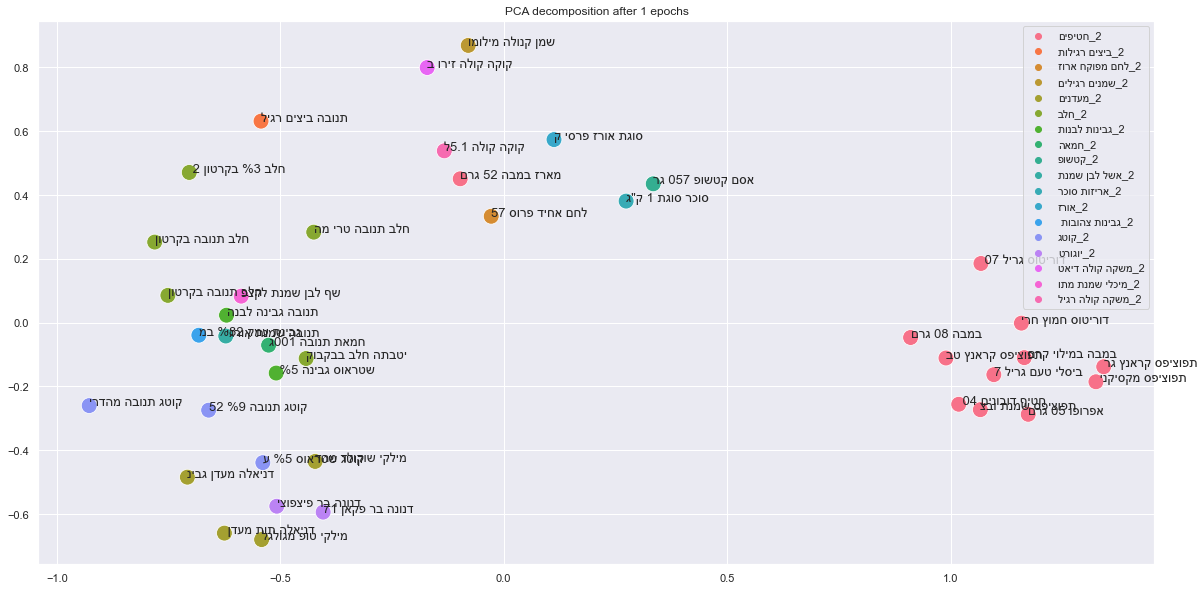

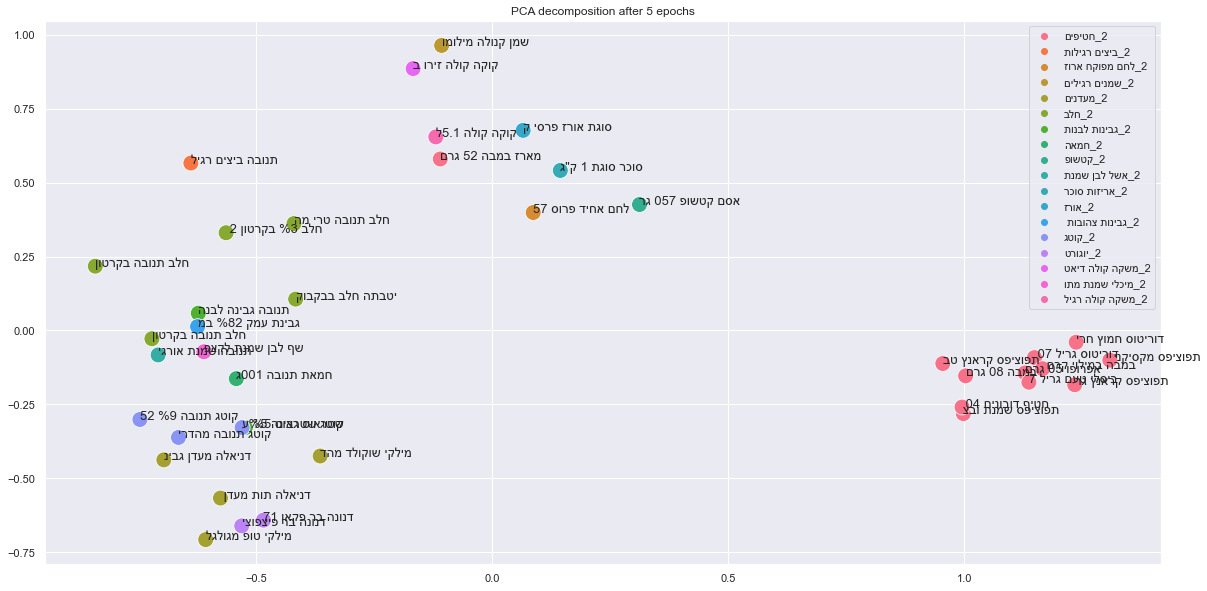

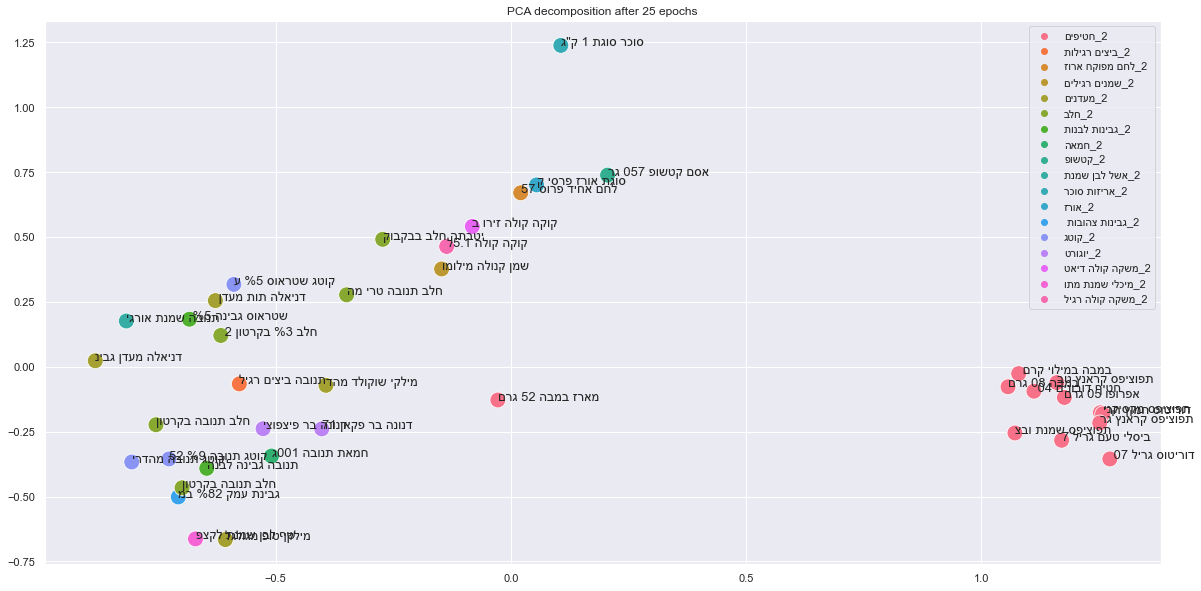

In [25]:
gensim_experiment(1)
gensim_experiment(5)
gensim_experiment(25)

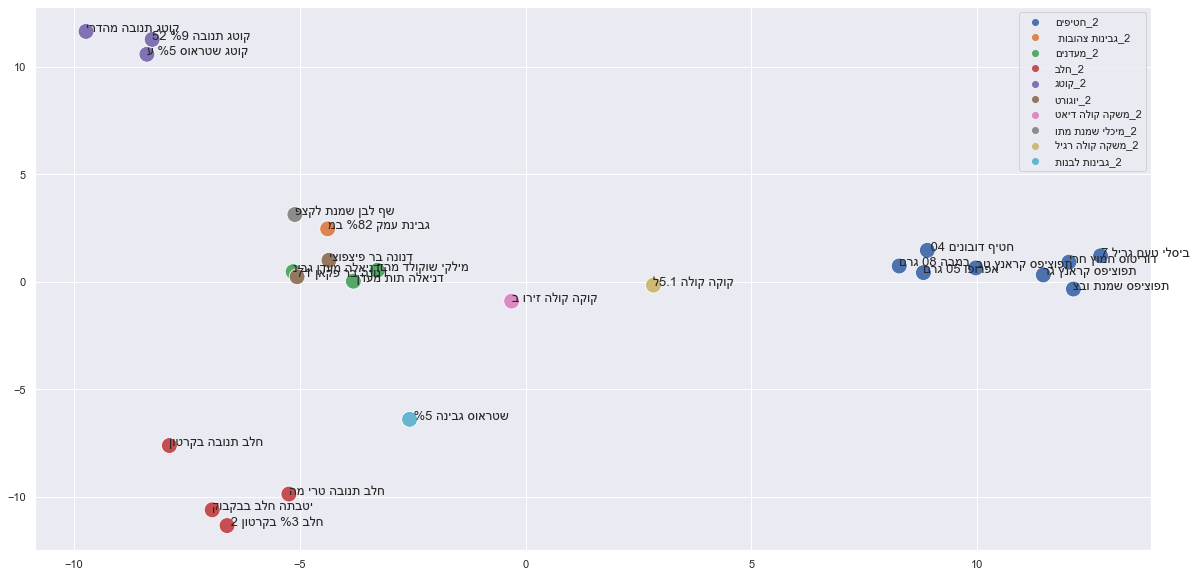

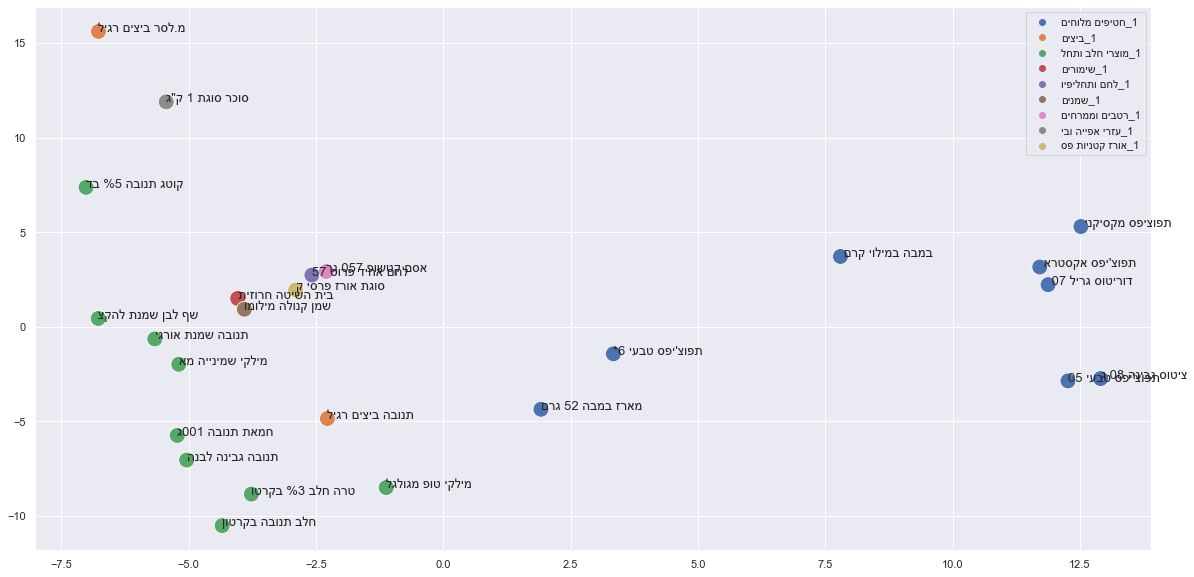

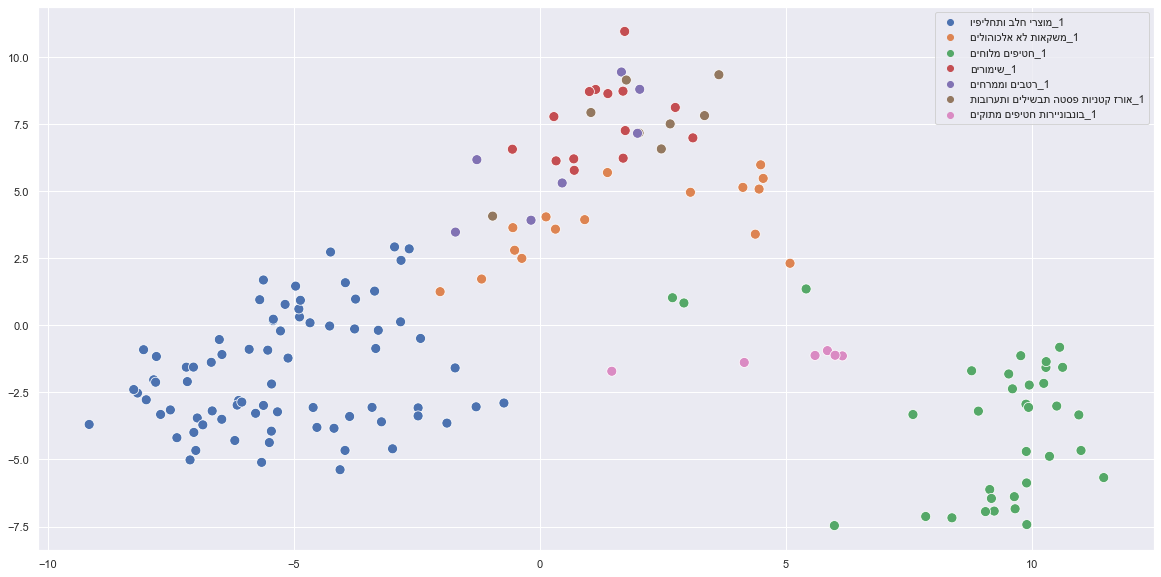

In [33]:


N_PRODUCTS = 40
sorted_indices = sorted(list(range(len(products))), key=lambda x: products[x].usages)[-25:]
X = np.vstack([gensim_skipgram.wv[str(x)] for x in sorted_indices])
pca = PCA(n_components=2)
pca.fit(X)
new = pca.transform(X) 
plt.figure(figsize=(20,10))
p = sns.scatterplot(new[:,0], new[:,1], hue=[products[x].hierarchy_names[2][15::-1] for x in current_barcodes], s=250)
for i,b in enumerate(current_barcodes):
    p.annotate(products_df.loc[b]['ITEM_NAME'][15::-1], (new[i,0], new[i,1]), fontsize=13)
p.set_title('PCA decomposition for learning rate ' + str(alpha))

In [ ]:

current_barcodes = list(tmp.sort_values('price').index[-200:])
categories = [products[x].hierarchy_names[1][::-1] for x in current_barcodes]
c = Counter(categories)
current_barcodes = [x for x in current_barcodes if c[products[x].hierarchy_names[1][::-1]] > 5]
X = np.vstack([vanilla_w2v[x] for x in current_barcodes])
pca = PCA(n_components=2)
pca.fit(X)
new = pca.transform(X) 
plt.figure(figsize=(20,10))
p = sns.scatterplot(new[:,0], new[:,1], hue=[products[x].hierarchy_names[1][::-1] for x in current_barcodes], s=100)

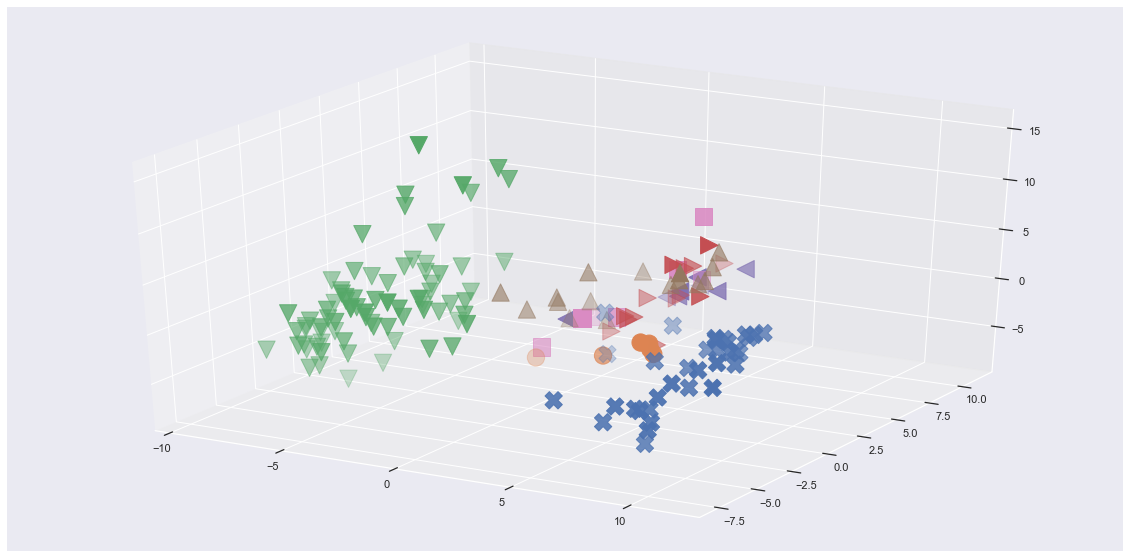

In [49]:
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3)
pca.fit(X)
new = pca.transform(X) 

types = set([products[x].hierarchy_names[1][::-1] for x in current_barcodes])
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

markers = ['X', 'o', 'v', '>', '<', '^', 's']
for j, t in enumerate(types):
    idx = [i for i in range(len(current_barcodes)) if products[current_barcodes[i]].hierarchy_names[1][::-1]==t]
    ax.scatter(new[idx, 0], new[idx,1], new[idx,2], marker=markers[j], s=300)
plt.show()



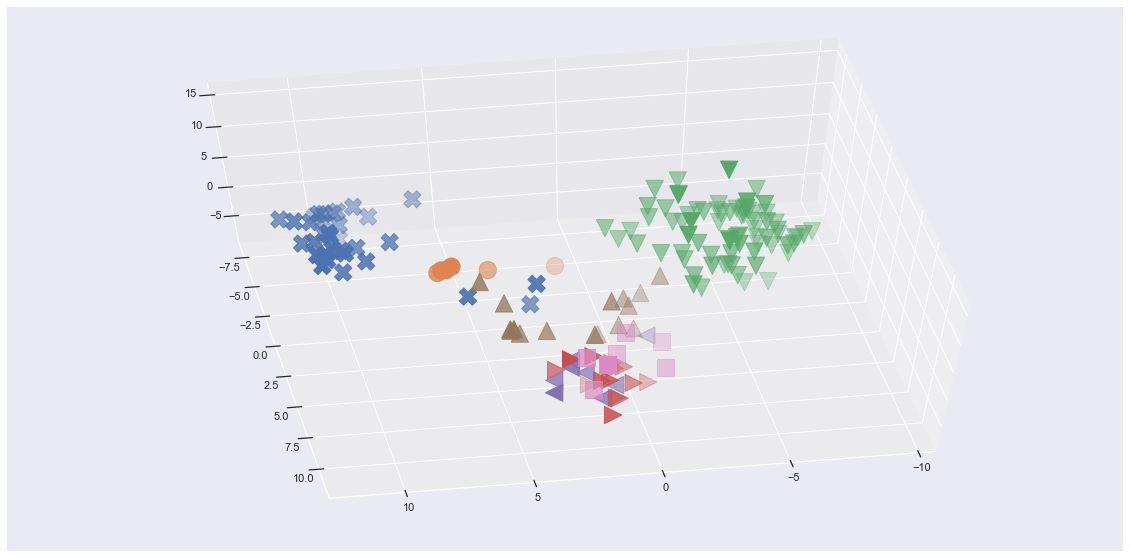

In [56]:


fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

for j, t in enumerate(types):
    idx = [i for i in range(len(current_barcodes)) if products[current_barcodes[i]].hierarchy_names[1][::-1]==t]
    ax.scatter(new[idx, 0], new[idx,1], new[idx,2], marker=markers[j], s=300)

ax.view_init(60,80)
plt.draw()